
# Zadanie: Analiza sentymentu – TensorFlow i PyTorch

## Cel
Twoim zadaniem jest stworzenie modelu, który rozpoznaje **sentyment tekstu** (np. pozytywny / negatywny) na podstawie danych wejściowych. Wykorzystaj poniższą bazową strukturę i rozbuduj ją samodzielnie.

---

## Dane wejściowe
Wykorzystaj zbiór danych z poprzedniej wersji zadania.

Przygotuj z nich sekwencje liczbowe (np. za pomocą `Tokenizer` lub ręcznie), a następnie przekształć na tensory.

---

## Architektura modelu
Zaprojektuj model o strukturze:
```
Input → Embedding → LSTM → Dense → Output (sigmoid lub softmax)
```

---

## (2pkt) Co należy zrobić:
1. Przygotuj dane wejściowe (tokenizacja, padding).
2. Zaimplementuj model w **TensorFlow (Keras)** i **PyTorch**.
3. Naucz model na danych treningowych.
4. Oceń skuteczność działania modelu (np. accuracy).
5. Dodaj komentarze i opisy do kodu.

---

## (2pkt) Rozszerzenia (dla chętnych):
- Spróbuj innych warstw (GRU, dodatkowe Dense, Dropout).
- Dodaj więcej warstw.
- Zaimplementuj wykres strat / metryk (np. matplotlib).
- Porównaj modele TF i PyTorch.

---

## Uwagi
- Model może być prosty – liczy się zrozumienie architektury i przepływu danych.
- Kod powinien być czytelny i skomentowany.
- Wydrukuj `model.summary()` (Keras) lub strukturę modelu (PyTorch).



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Colab
from IPython import get_ipython


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/amazon.csv')
df.head()


texts = df['reviewText'].tolist()
labels = df['Positive'].tolist()

In [3]:
# Inicjalizacja tokenizera
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(texts)

# Konwersja tekstów na sekwencje liczbowe
sequences = tokenizer.texts_to_sequences(texts)

# Padding sekwencji do tej samej długości
max_sequence_length = max([len(x) for x in sequences])

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Konwersja etykiet na numpy array
labels = np.array(labels)

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

print("Kształt danych treningowych (X_train):", X_train.shape)
print("Kształt etykiet treningowych (y_train):", y_train.shape)
print("Kształt danych testowych (X_test):", X_test.shape)
print("Kształt etykiet testowych (y_test):", y_test.shape)

Kształt danych treningowych (X_train): (16000, 62)
Kształt etykiet treningowych (y_train): (16000,)
Kształt danych testowych (X_test): (4000, 62)
Kształt etykiet testowych (y_test): (4000,)


# Tensorflow Prosty model

In [4]:
# Definicja parametrów modelu
vocab_size = 10000  # Rozmiar słownika (taki sam jak num_words z tokenizera)
embedding_dim = 16  # Wymiar wektorów słów
lstm_units = 32     # Liczba jednostek w warstwie LSTM
output_dim = 1      # 1 dla klasyfikacji binarnej

# Budowa modelu
model_tf = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    LSTM(lstm_units),
    Dense(output_dim, activation='sigmoid')
])

# Kompilacja modelu
model_tf.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Wyświetlenie struktury modelu
model_tf.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
history_tf = model_tf.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Ocena modelu TensorFlow na danych testowych
loss_tf_test, accuracy_tf_test = model_tf.evaluate(X_test, y_test)

# Zapisanie metryk z historii treningu (strata i dokładność na zbiorze treningowym i walidacyjnym na każdej epoce)
train_loss_history_tf = history_tf.history['loss']
val_loss_history_tf = history_tf.history['val_loss']
train_accuracy_history_tf = history_tf.history['accuracy']
val_accuracy_history_tf = history_tf.history['val_accuracy']

# Zapisanie finalnych metryk na zbiorze testowym
final_loss_tf = loss_tf_test
final_accuracy_tf = accuracy_tf_test

print("\nTensorFlow - Finalne metryki na zbiorze testowym:")
print(f"  Loss: {final_loss_tf}")
print(f"  Accuracy: {final_accuracy_tf}")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.7489 - loss: 0.5689 - val_accuracy: 0.7605 - val_loss: 0.5503
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7541 - loss: 0.5344 - val_accuracy: 0.7605 - val_loss: 0.5455
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7651 - loss: 0.5401 - val_accuracy: 0.7605 - val_loss: 0.5463
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7573 - loss: 0.5495 - val_accuracy: 0.7605 - val_loss: 0.5467
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.7669 - loss: 0.5393 - val_accuracy: 0.7605 - val_loss: 0.5493
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7635 - loss: 0.5460 - val_accuracy: 0.7605 - val_loss: 0.5505
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.7708 - loss: 0.5370 - val_accuracy: 0.7605 - val_loss: 0.5499
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7609 - loss: 0.5485 - 

# Pytorch Prosty model

In [8]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden.squeeze(0)
        return self.fc(hidden)

# --- Pytorch Prosty model ---

class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Definition of parameters
vocab_size_pt = 10000  # Should match num_words from tokenizer
embedding_dim_pt = 16
hidden_dim_pt = 32
output_dim_pt = 1

# Instantiate the model
model_pt = SentimentLSTM(vocab_size_pt, embedding_dim_pt, hidden_dim_pt, output_dim_pt)

# Define Loss function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_pt.parameters())

In [9]:
# --- Pytorch Prosty model ---

# Convert training data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.long)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Create Dataset and DataLoader for training data
train_dataset = SentimentDataset(X_train_torch, y_train_torch)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Convert test data to PyTorch tensors (already done, but ensure it's before test_dataloader)
X_test_torch = torch.tensor(X_test, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for test data (for evaluation)
test_dataset = SentimentDataset(X_test_torch, y_test_torch)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Listy do przechowywania metryk z każdej epoki
train_loss_history_pt = []
val_loss_history_pt = []
val_accuracy_history_pt = []

# Trenowanie modelu PyTorch
num_epochs = 10

for epoch in range(num_epochs):
    model_pt.train()
    running_train_loss = 0.0

    # --- Pętla treningowa dla danej epoki ---
    for sequences_batch, labels_batch in dataloader:
        # 1. Zerowanie gradientów
        optimizer.zero_grad()

        # 2. Propagacja w przód (Forward pass)
        outputs = model_pt(sequences_batch)

        # 3. Obliczenie straty
        loss = criterion(outputs.squeeze(), labels_batch)

        # 4. Propagacja wstecz (Backward pass)
        loss.backward()

        # 5. Aktualizacja wag (Optimizer step)
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(dataloader)
    train_loss_history_pt.append(epoch_train_loss)

    # --- Etap Ewaluacji po każdej epoce ---
    model_pt.eval()
    total_correct = 0
    total_samples = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for sequences_batch, labels_batch in test_dataloader:

            outputs = model_pt(sequences_batch)
            loss = criterion(outputs.squeeze(), labels_batch)
            running_val_loss += loss.item()

            # Oblicz dokładność dla batcha
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total_samples += labels_batch.size(0)
            total_correct += (predicted == labels_batch).sum().item()

    epoch_val_loss = running_val_loss / len(test_dataloader)
    epoch_val_accuracy = total_correct / total_samples

    val_loss_history_pt.append(epoch_val_loss)
    val_accuracy_history_pt.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

# --- Ocena modelu PyTorch na danych testowych (po zakończeniu treningu) ---
model_pt.eval()
total_correct_final = 0
total_samples_final = 0
test_loss_pt_final = 0.0

with torch.no_grad():
    for sequences_batch, labels_batch in test_dataloader:
        outputs = model_pt(sequences_batch)
        loss = criterion(outputs.squeeze(), labels_batch)
        test_loss_pt_final += loss.item()

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))

        total_samples_final += labels_batch.size(0)
        total_correct_final += (predicted == labels_batch).sum().item()

final_test_loss_pt = test_loss_pt_final / len(test_dataloader)
final_test_accuracy_pt = total_correct_final / total_samples_final

print("\nPyTorch - Finalne metryki na zbiorze testowym (po treningu):")
print(f"  Loss: {final_test_loss_pt:.4f}")
print(f"  Accuracy: {final_test_accuracy_pt:.4f}")


Epoch 1/10, Train Loss: 0.5539, Val Loss: 0.5525, Val Accuracy: 0.7605
Epoch 2/10, Train Loss: 0.5493, Val Loss: 0.5505, Val Accuracy: 0.7605
Epoch 3/10, Train Loss: 0.5495, Val Loss: 0.5509, Val Accuracy: 0.7605
Epoch 4/10, Train Loss: 0.5495, Val Loss: 0.5518, Val Accuracy: 0.7605
Epoch 5/10, Train Loss: 0.5494, Val Loss: 0.5504, Val Accuracy: 0.7605
Epoch 6/10, Train Loss: 0.5492, Val Loss: 0.5504, Val Accuracy: 0.7605
Epoch 7/10, Train Loss: 0.5527, Val Loss: 0.5557, Val Accuracy: 0.7605
Epoch 8/10, Train Loss: 0.5495, Val Loss: 0.5506, Val Accuracy: 0.7605
Epoch 9/10, Train Loss: 0.5491, Val Loss: 0.5509, Val Accuracy: 0.7605
Epoch 10/10, Train Loss: 0.5494, Val Loss: 0.5518, Val Accuracy: 0.7605

PyTorch - Finalne metryki na zbiorze testowym (po treningu):
  Loss: 0.5518
  Accuracy: 0.7605


# Tensorflow rozbudowany model

In [11]:
# --- Rozszerzony model TensorFlow (przykład z Dropoutem) ---

# Budowa rozszerzonego modelu TensorFlow
model_tf_extended = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    LSTM(lstm_units),
    tf.keras.layers.Dropout(0.5),
    Dense(output_dim, activation='sigmoid')
])

# Kompilacja modelu
model_tf_extended.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

# Wyświetlenie struktury modelu
print("\nRozszerzony model TensorFlow:")
model_tf_extended.summary()

# Trening rozszerzonego modelu TensorFlow
history_tf_extended = model_tf_extended.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Ocena rozszerzonego modelu TensorFlow na danych testowych
loss_tf_extended_test, accuracy_tf_extended_test = model_tf_extended.evaluate(X_test, y_test)

# Zapisanie metryk z historii treningu
train_loss_history_tf_extended = history_tf_extended.history['loss']
val_loss_history_tf_extended = history_tf_extended.history['val_loss']
train_accuracy_history_tf_extended = history_tf_extended.history['accuracy']
val_accuracy_history_tf_extended = history_tf_extended.history['val_accuracy']

# Zapisanie finalnych metryk na zbiorze testowym
final_loss_tf_extended = loss_tf_extended_test
final_accuracy_tf_extended = accuracy_tf_extended_test

print("\nTensorFlow Extended - Finalne metryki na zbiorze testowym:")
print(f"  Loss: {final_loss_tf_extended}")
print(f"  Accuracy: {final_accuracy_tf_extended}")


Rozszerzony model TensorFlow:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7606 - loss: 0.5715 - val_accuracy: 0.7605 - val_loss: 0.5514
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7589 - loss: 0.5586 - val_accuracy: 0.7605 - val_loss: 0.5507
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7665 - loss: 0.5417 - val_accuracy: 0.8307 - val_loss: 0.4428
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8453 - loss: 0.4303 - val_accuracy: 0.7673 - val_loss: 0.4160
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8442 - loss: 0.3856 - val_accuracy: 0.8447 - val_loss: 0.4312
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8334 - loss: 0.4579 - val_accuracy: 0.8273 - val_loss: 0.4579
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8332 - loss: 0.4560 - val_accuracy: 0.8390 - val_loss: 0.4404
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8407 - loss: 0.4419 - 

# Pytorch rozbudowany model

In [12]:
# --- Pytorch Prosty model ---

# Konwersja danych testowych na tensory PyTorch
X_test_torch = torch.tensor(X_test, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Utworzenie DataLoader dla danych testowych (do ewaluacji w trakcie treningu)
test_dataset = SentimentDataset(X_test_torch, y_test_torch)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Listy do przechowywania metryk z każdej epoki
train_loss_history_pt_extended = [] # <-- NEW variable
val_loss_history_pt_extended = []   # <-- NEW variable
val_accuracy_history_pt_extended = []

# Trenowanie modelu PyTorch
num_epochs = 10

for epoch in range(num_epochs):
    model_pt.train()
    running_train_loss = 0.0

    # --- Pętla treningowa dla danej epoki ---
    for sequences_batch, labels_batch in dataloader:

        # 1. Zerowanie gradientów
        optimizer.zero_grad()

        # 2. Propagacja w przód (Forward pass)
        outputs = model_pt(sequences_batch)

        # 3. Obliczenie straty
        loss = criterion(outputs.squeeze(), labels_batch)

        # 4. Propagacja wstecz (Backward pass)
        loss.backward()

        # 5. Aktualizacja wag (Optimizer step)
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(dataloader)

    train_loss_history_pt_extended.append(epoch_train_loss)

    # --- Etap Ewaluacji po każdej epoce ---
    model_pt.eval()
    total_correct = 0
    total_samples = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for sequences_batch, labels_batch in test_dataloader:
            outputs = model_pt(sequences_batch)
            loss = criterion(outputs.squeeze(), labels_batch)
            running_val_loss += loss.item()

            # Oblicz dokładność dla batcha
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total_samples += labels_batch.size(0)
            total_correct += (predicted == labels_batch).sum().item()

    epoch_val_loss = running_val_loss / len(test_dataloader)
    epoch_val_accuracy = total_correct / total_samples

    val_loss_history_pt_extended.append(epoch_val_loss)
    val_accuracy_history_pt_extended.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

# --- Ocena modelu PyTorch na danych testowych (po zakończeniu treningu) ---
model_pt.eval()
total_correct_final = 0
total_samples_final = 0
test_loss_pt_final = 0.0

with torch.no_grad():
    for sequences_batch, labels_batch in test_dataloader:
        # ... (przenieś na urządzenie)
        outputs = model_pt(sequences_batch)
        loss = criterion(outputs.squeeze(), labels_batch)
        test_loss_pt_final += loss.item()

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))

        total_samples_final += labels_batch.size(0)
        total_correct_final += (predicted == labels_batch).sum().item()

# Corrected variable names here
final_test_loss_pt_extended = test_loss_pt_final / len(test_dataloader)
final_test_accuracy_pt_extended = total_correct_final / total_samples_final

print("\nPyTorch - Finalne metryki na zbiorze testowym (po treningu):")
print(f"  Loss: {final_test_loss_pt_extended:.4f}")
print(f"  Accuracy: {final_test_accuracy_pt_extended:.4f}")



Epoch 1/10, Train Loss: 0.5491, Val Loss: 0.5508, Val Accuracy: 0.7605
Epoch 2/10, Train Loss: 0.5494, Val Loss: 0.5505, Val Accuracy: 0.7605
Epoch 3/10, Train Loss: 0.5494, Val Loss: 0.5504, Val Accuracy: 0.7605
Epoch 4/10, Train Loss: 0.5490, Val Loss: 0.5504, Val Accuracy: 0.7605
Epoch 5/10, Train Loss: 0.5392, Val Loss: 0.5185, Val Accuracy: 0.7608
Epoch 6/10, Train Loss: 0.5100, Val Loss: 0.4820, Val Accuracy: 0.7605
Epoch 7/10, Train Loss: 0.4765, Val Loss: 0.4390, Val Accuracy: 0.8135
Epoch 8/10, Train Loss: 0.4137, Val Loss: 0.3928, Val Accuracy: 0.8335
Epoch 9/10, Train Loss: 0.3536, Val Loss: 0.3449, Val Accuracy: 0.8598
Epoch 10/10, Train Loss: 0.3067, Val Loss: 0.3437, Val Accuracy: 0.8462

PyTorch - Finalne metryki na zbiorze testowym (po treningu):
  Loss: 0.3437
  Accuracy: 0.8462


# Porównanie wyników

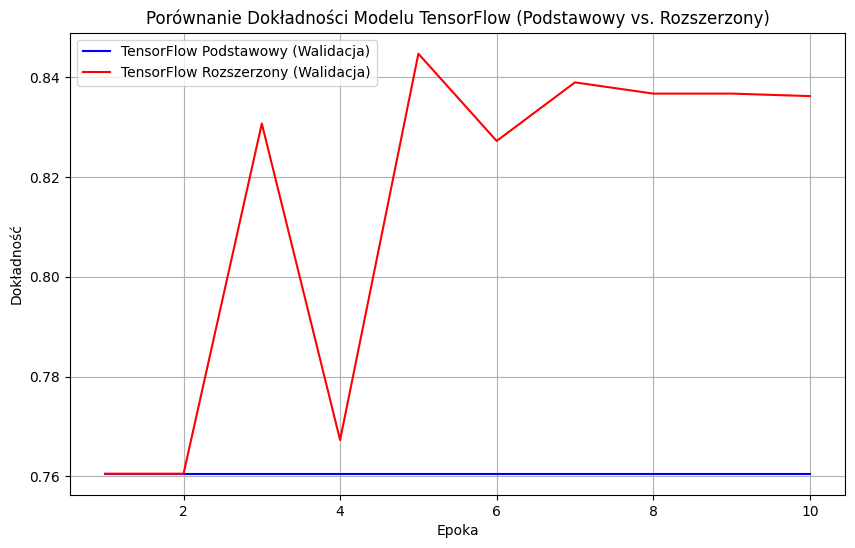

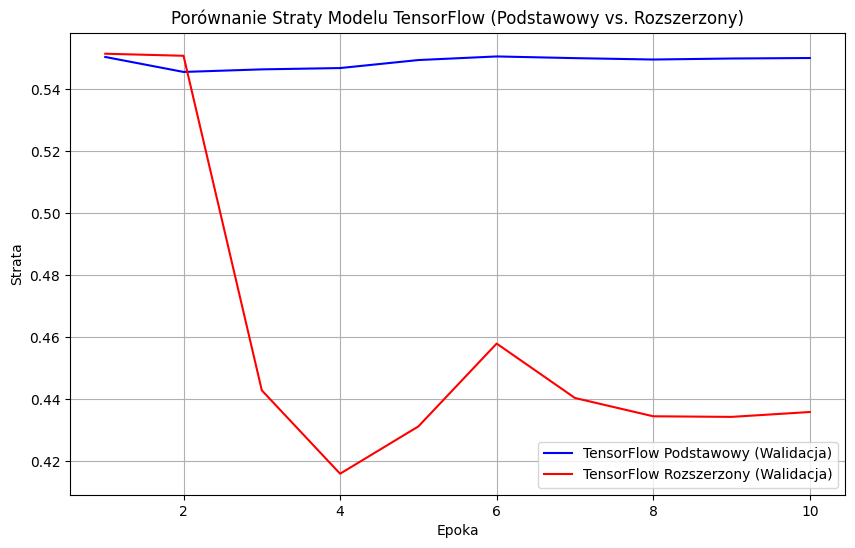

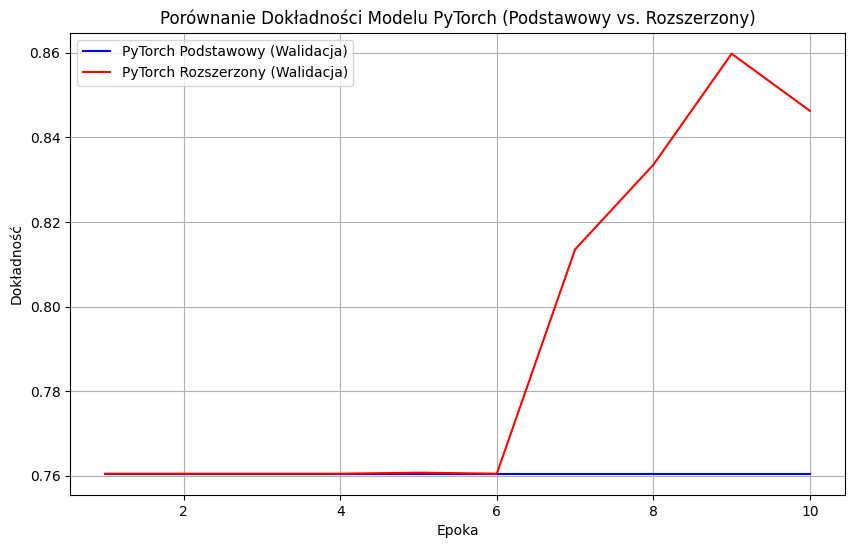

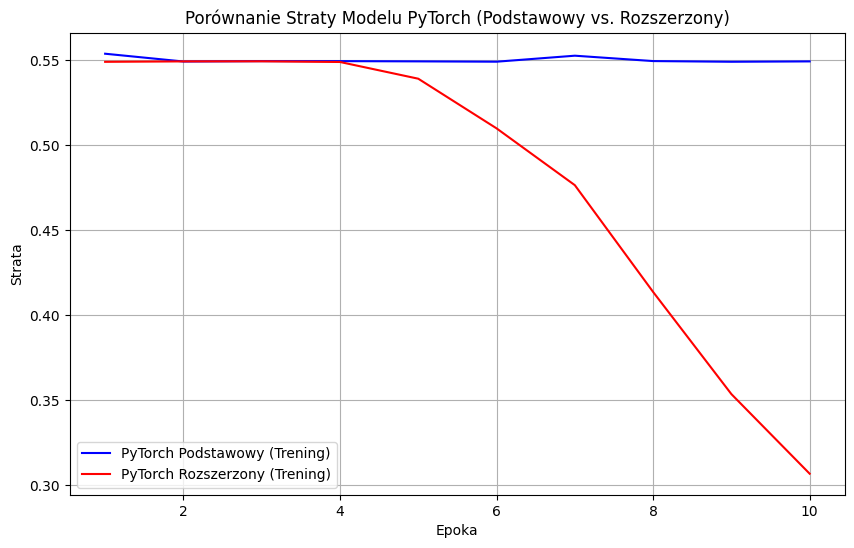


Finalne Metryki Porównania:


In [13]:
epochs = range(1, len(train_accuracy_history_tf) + 1)

# --- Wykres 1: Accuracy TensorFlow (Podstawowy vs. Rozszerzony) ---
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy_history_tf, 'b', label='TensorFlow Podstawowy (Walidacja)')
plt.plot(epochs, val_accuracy_history_tf_extended, 'r', label='TensorFlow Rozszerzony (Walidacja)')
plt.title('Porównanie Dokładności Modelu TensorFlow (Podstawowy vs. Rozszerzony)')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()

# --- Wykres 2: Loss TensorFlow (Podstawowy vs. Rozszerzony) ---
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss_history_tf, 'b', label='TensorFlow Podstawowy (Walidacja)')
plt.plot(epochs, val_loss_history_tf_extended, 'r', label='TensorFlow Rozszerzony (Walidacja)')
plt.title('Porównanie Straty Modelu TensorFlow (Podstawowy vs. Rozszerzony)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)
plt.show()

# Liczba epok dla PyTorch (zakładamy, że oba modele były trenowane przez tyle samo epok)
epochs_pt = range(1, len(train_loss_history_pt) + 1)

# --- Wykres 3: Accuracy PyTorch (Podstawowy vs. Rozszerzony) ---
plt.figure(figsize=(10, 6))
plt.plot(epochs_pt, val_accuracy_history_pt, 'b', label='PyTorch Podstawowy (Walidacja)')
plt.plot(epochs_pt, val_accuracy_history_pt_extended, 'r', label='PyTorch Rozszerzony (Walidacja)')
plt.title('Porównanie Dokładności Modelu PyTorch (Podstawowy vs. Rozszerzony)')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()



# --- Wykres 4: Loss PyTorch (Podstawowy vs. Rozszerzony) ---
plt.figure(figsize=(10, 6))
plt.plot(epochs_pt, train_loss_history_pt, 'b', label='PyTorch Podstawowy (Trening)')
plt.plot(epochs_pt, train_loss_history_pt_extended, 'r', label='PyTorch Rozszerzony (Trening)') # <-- Corrected variable name
plt.title('Porównanie Straty Modelu PyTorch (Podstawowy vs. Rozszerzony)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)
plt.show()

# Możesz również wyświetlić finalne metryki dla porównania:
print("\nFinalne Metryki Porównania:")